In [71]:
# Pacotes úteis
import matplotlib.pyplot as plt  # para os gráficos
import numpy as np  # para operações matemáticas

# %matplotlib notebook
# %matplotlib ipympl

# opções de figuras
plt.rcParams["font.family"] = ["serif"]
plt.rcParams["font.serif"] = ["Times New Roman"]
plt.rcParams["figure.autolayout"] = True
plt.rcParams["text.usetex"] = True

SMALL_SIZE = 14
MEDIUM_SIZE = 18
BIGGER_SIZE = 22

plt.rc("font", size=SMALL_SIZE)  # controls default text sizes
plt.rc("axes", titlesize=SMALL_SIZE)  # fontsize of the axes title
plt.rc("axes", labelsize=MEDIUM_SIZE)  # fontsize of the x and y labels
plt.rc("xtick", labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc("ytick", labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc("legend", fontsize=MEDIUM_SIZE)  # legend fontsize
plt.rc("figure", titlesize=BIGGER_SIZE)  # fontsize of the figure title


## Definição do Problema
Devemos simular a vibração de um poste de semáforo do tipo braço projetado que esteja balançando ao vento sob as condições presentes na avenida Dante Michelini, Vitória-ES.

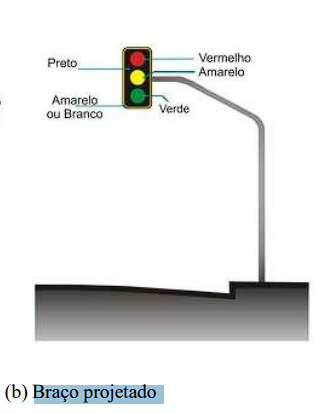



## Modelagem mátemática
<img src=croqui.svg width="500" length="500" style = "display:block; margin-left: auto; margin-right: auto">
As dimensões de postes do tipo estudado são:

| Simbolos | Dimensões|
|---|---|
| H | 5,5 m |
| L | 4,7 m |
| D | 0,114 m|
| t | 0,0045 m|

**O braço tem dimensões diferentes do poste engastado.

Foi escolhido utilizar um modelo de 6 graus de liberdade baseado na viga de Euler-Bernulli.
<img src=Frame1.svg width="800" style = "display: block; margin-left: auto; margin-right: auto">

In [72]:
# Defininido as matrizes de massa, rigidez e transformação
def StiffnessFrame(E, A, I, L):
    """
    Calcula a matriz de rigidez de um elemento de pórtico.

    Parâmetros:
    E (float): Módulo de elasticidade do material.
    A (float): Área da seção transversal do elemento.
    I (float): Momento de inércia da seção transversal do elemento.
    L (float): Comprimento do elemento.

    Retorna:
    numpy.ndarray: Matriz de rigidez do elemento de pórtico.
    """
    K = (
        E
        * I
        / (L**3)
        * np.array(
            [
                [A * (L**2) / I, 0, 0, -A * (L**2) / I, 0, 0],
                [0, 12, 6 * L, 0, -12, 6 * L],
                [0, 6 * L, 4 * (L**2), 0, -6 * L, 2 * (L**2)],
                [-A * (L**2) / I, 0, 0, A * (L**2) / I, 0, 0],
                [0, -12, -6 * L, 0, 12, -6 * L],
                [0, 6 * L, 2 * (L**2), 0, -6 * L, 4 * (L**2)],
            ]
        )
    )
    return K


def MassFrame(rho, A, L):
    """
    Calcula a matriz de massa para um elemento de pórtico.

    Parâmetros:
    rho (float): Densidade do material.
    A (float): Área da seção transversal do elemento do pórtico.
    L (float): Comprimento do elemento do pórtico.

    Retorna:
    numpy.ndarray: Uma matriz de massa 6x6 para o elemento do pórtico.
    """
    M = (
        rho
        * A
        * L
        / (420)
        * np.array(
            [
                [140, 0, 0, 70, 0, 0],
                [0, 156, 22 * L, 0, 54, -13 * L],
                [0, 22 * L, 4 * (L**2), 0, 13 * L, -3 * (L**2)],
                [70, 0, 0, 140, 0, 0],
                [0, 54, 13 * L, 0, 156, -22 * L],
                [0, -13 * L, -3 * (L**2), 0, -22 * L, 4 * (L**2)],
            ]
        )
    )
    return M


def TransformationMatrix(s_theta, c_theta):
    """
    Gera uma matriz de transformação para um dado seno e cosseno de um ângulo.
    Parâmetros:
    s_theta (float): Seno do ângulo.
    c_theta (float): Cosseno do ângulo.
    Retorna:
    numpy.ndarray: Uma matriz de transformação 6x6.
    """
    T = np.array(
        [
            [c_theta, s_theta, 0, 0, 0, 0],
            [-s_theta, c_theta, 0, 0, 0, 0],
            [0, 0, 1, 0, 0, 0],
            [0, 0, 0, c_theta, s_theta, 0],
            [0, 0, 0, -s_theta, c_theta, 0],
            [0, 0, 0, 0, 0, 1],
        ]
    )
    return T


In [73]:
# Propriedades mecânicas do poste (Aço SAE 1010).
E = 205e3  # Módulo de elasticidade (MPa)
rho = 7850  # Densidade (kg/m³)

# Dimensões do poste.
H = 4.90  # Altura (m)
L = 4.70  # Comprimento (m)
t = 0.0045  # Espessura (m)
D = 0.114  # Diâmetro (m)
A = np.pi * (D**2 - (D - 2 * t) ** 2) / 4  # Área (m²)
I = np.pi * (D**4 - (D - 2 * t) ** 4) / 64  # Inércia (m⁴)


In [74]:
# # Montando as matrizes globais
n_elementos = 2
l = L / n_elementos  # Dividindo a barra de acordo com o número de elementos
M = np.zeros((3 * n_elementos + 3, 3 * n_elementos + 3))  # matriz de massa
K = np.zeros((3 * n_elementos + 3, 3 * n_elementos + 3))  # matriz de rigidez

# Fazendo na viga vertical:
T = TransformationMatrix(1, 0)
K[0:6, 0:6] = np.dot(T.transpose(), np.dot(StiffnessFrame(E, A, I, l), T))
M[0:6, 0:6] = np.dot(T.transpose(), np.dot(MassFrame(rho, A, l), T))

# Fazendo na viga horizontal:
T = TransformationMatrix(0, 1)
K[3:9, 3:9] = K[3:9, 3:9] + np.dot(T.transpose(), np.dot(StiffnessFrame(E, A, I, l), T))
M[3:9, 3:9] = M[3:9, 3:9] + np.dot(T.transpose(), np.dot(MassFrame(rho, A, l), T))

# Adicionando a massa do semáforo (15 kg) no último nó:
M[-3, -3] += 15
M[-2, -2] += 15


#### Condições de contorno:

##### Engastada:
$u_0$ = 0;

$u_1$ = 0;

$u_2$ = 0;

In [75]:
## Engastado no inicio.
K = np.delete(K, (0, 1, 2), axis=0)
K = np.delete(K, (0, 1, 2), axis=1)
M = np.delete(M, (0, 1, 2), axis=0)
M = np.delete(M, (0, 1, 2), axis=1)


### Amortecimento Proporcional


In [76]:
alpha = 0.1  # amortecimento proporcional
beta = 0.000001  # amortecimento proporcional

C = alpha * M + beta * K  # amortecimento proporcional


## Análise Modal


In [77]:
# 1: L^-1:
L_chol = np.linalg.cholesky(M)
L_chol_inv = np.linalg.inv(L_chol)

# 2: K_tiu
K_tiu = np.dot(L_chol_inv, np.dot(K, L_chol_inv.transpose()))

# 3: problema de autovalor
a, b = np.linalg.eig(
    K_tiu
)  # a são autovalores e b autovetores (cada coluna de b é 1 autovetor)

wn = np.sqrt(a)  # vetor com as frequências naturais
v = b

# ordenar da menor para a maior frequência
v = v[:, np.argsort(wn)]
wn = np.sort(wn)

P = v  # a matriz P vai ser a própria matriz v que já contém todos os autovetores

S = np.dot(L_chol_inv.transpose(), P)  # da coordenada x para r
S_inv = np.dot(np.transpose(P), L_chol.transpose())  # da coordenada r para x

zeta_i = alpha / (2 * wn) + beta * wn / 2

print("Fatores de amortecimento:", zeta_i[0:4], "\n")
print("Frequências Naturais [Hz]:", wn[0:4] / 2 / np.pi, "\n")
# print("Frequências Naturais Analiticamente [Hz]:", w_alalitico / 2 / np.pi, "\n")


Fatores de amortecimento: [1.71372296 0.60625679 0.09519132 0.03735597] 

Frequências Naturais [Hz]: [0.00464354 0.01312603 0.08359763 0.21302859] 



### Modos de Vibrar

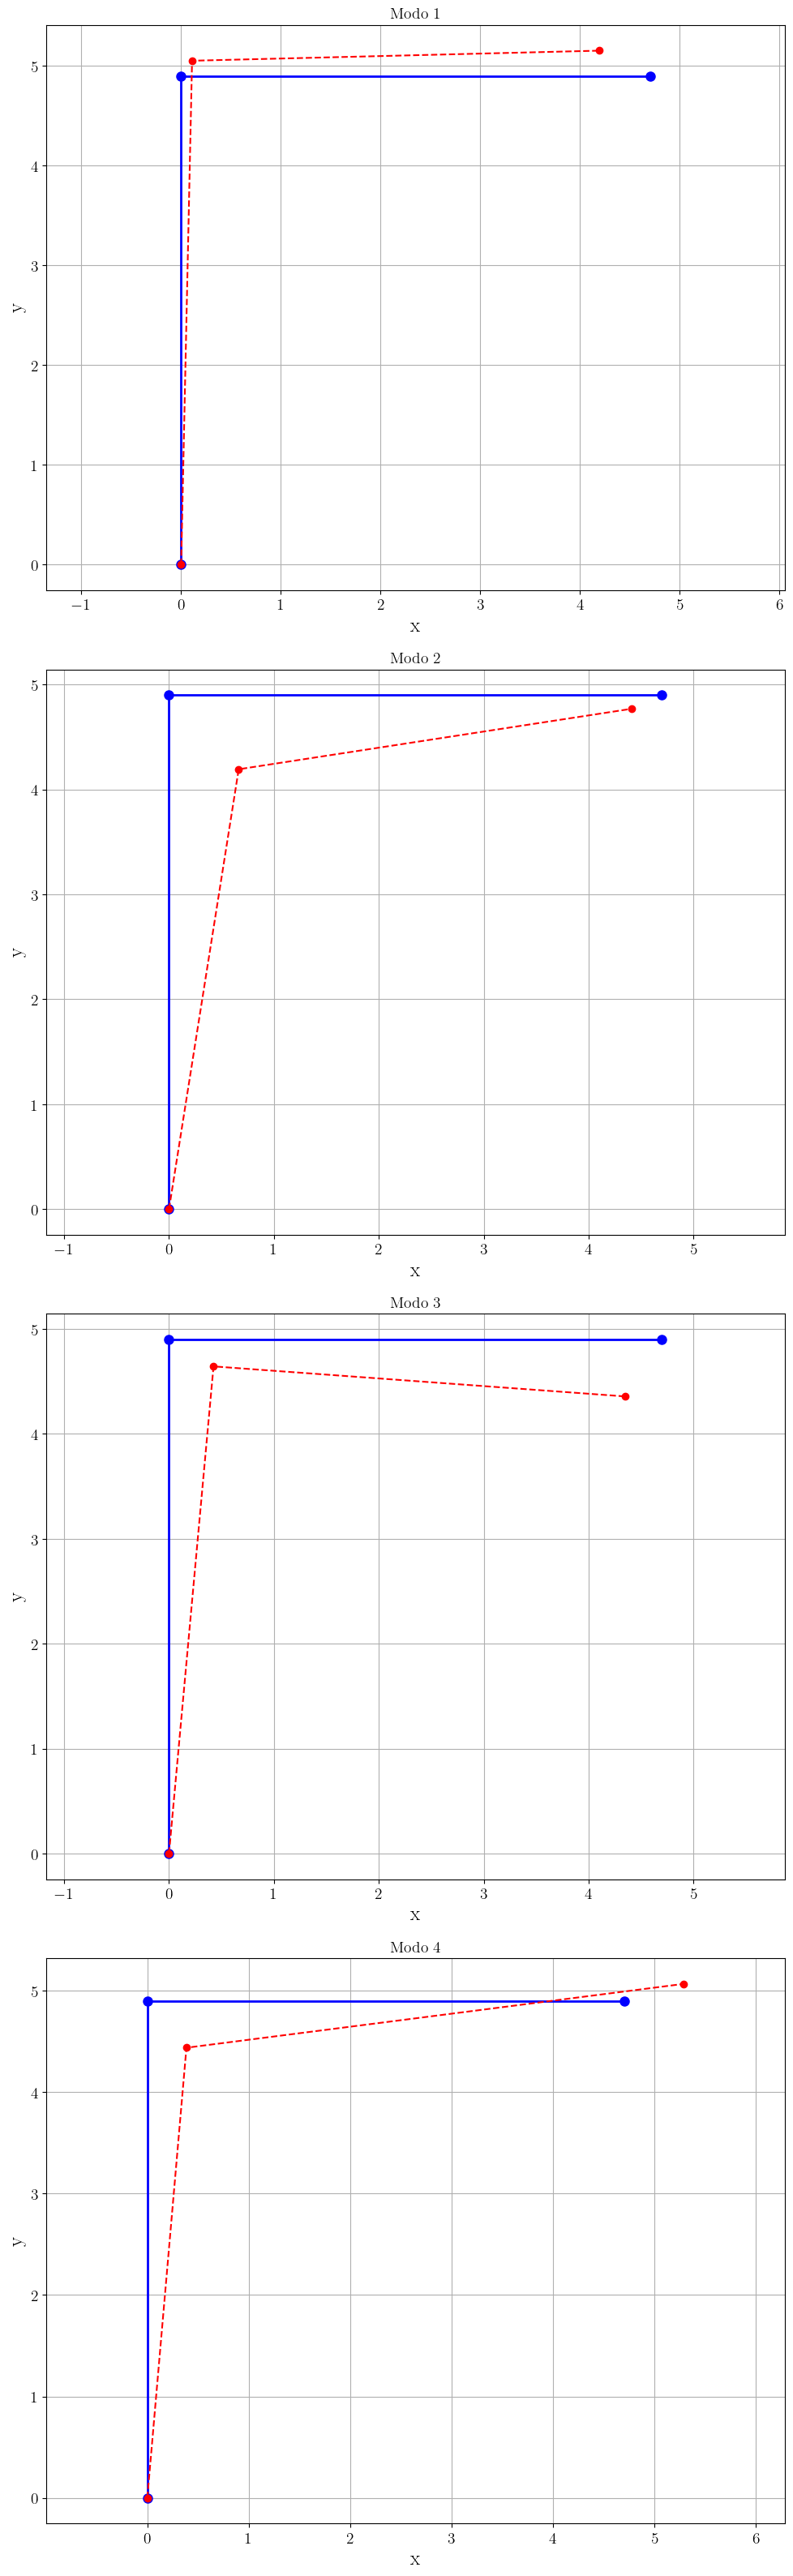

In [78]:
n_nos = 3

# Coordenadas dos nós (exemplo: L-shaped)
x_nos = np.array([0, 0, L])
y_nos = np.array([0, H, H])

# Suponha que S é a matriz de autovetores (3 DOFs por nó)
# Exemplo: S.shape = (3 * n_nos, n_modos)
n_modos = 4
S = np.random.randn(3 * n_nos, n_modos)  # Substitua por seus autovetores reais

# Fator de escala para visualização
scale = 0.5

# Extrair deslocamentos em x e y
x_modo = np.zeros((n_nos, n_modos))
y_modo = np.zeros((n_nos, n_modos))

for i in range(n_modos):
    u_x = S[0::3, i]  # DOFs em x (0, 3, 6, ...)
    u_y = S[1::3, i]  # DOFs em y (1, 4, 7, ...)

    x_modo[:, i] = x_nos + scale * u_x
    y_modo[:, i] = y_nos + scale * u_y

# Fixar o primeiro nó (suporte)
x_modo[0, :] = x_nos[0]
y_modo[0, :] = y_nos[0]

# Plotar
fig, axs = plt.subplots(n_modos, 1, figsize=(10, 8 * n_modos))
for i in range(n_modos):
    axs[i].plot(x_nos, y_nos, "-ob", linewidth=2, markersize=8)
    axs[i].plot(x_modo[:, i], y_modo[:, i], "--or", linewidth=1.5, markersize=6)
    axs[i].grid(True)
    axs[i].set_title(f"Modo {i + 1}", fontsize=14)
    axs[i].set_xlabel("x")
    axs[i].set_ylabel("y")
    axs[i].axis("equal")

plt.tight_layout()
plt.show()
